# MakeTimePlotsForHCERES2024


- creation date : 2024-01-21
- update : 2024-01-22

In [1]:
import os,sys,re
import h5py # one standard python package to work on hdf5 file


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns 
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


## Merra 2

In [3]:
top_merra2 = "../../../Merra2"

In [4]:
asm_merra2 = ["MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [5]:
aer_merra2 = ["MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [6]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [7]:
df_asm_all = pd.concat(df_asm)
df_aer_all = pd.concat(df_aer)

## Auxtel data

In [8]:
path = "Data_Auxtel_FittAtm"

In [9]:
list_of_files = sorted(os.listdir(path))
list_of_files

['out_allfittedparams_selected_27sept-07dec2023.csv']

In [10]:
df = pd.read_csv(os.path.join(path,list_of_files[0]))

In [11]:
df_columns_list  = list(df.columns)
#for varname in df_columns_list:
#    print(varname)
df[["DATE-OBS","id"]] 

,DATE-OBS,id
0,2023-09-28 00:17:22.483504618+00:00,2023092700216
1,2023-09-28 00:20:51.389002941+00:00,2023092700222
2,2023-09-28 00:21:25.064995394+00:00,2023092700223
3,2023-09-28 00:22:32.406005680+00:00,2023092700225
4,2023-09-28 00:24:47.020494847+00:00,2023092700229
...,...,...
570,2023-12-08 03:44:50.441503941+00:00,2023120700421
571,2023-12-08 04:02:32.741498325+00:00,2023120700434
572,2023-12-08 04:03:45.754501796+00:00,2023120700435
573,2023-12-08 04:50:25.591008638+00:00,2023120700452


### Calculate the nightObs number from the exposure Id

In [12]:
df["nightObs"] = df.apply(lambda x: x['id']//100_000, axis=1)

In [13]:
df[["DATE-OBS","id","nightObs"]] 

,DATE-OBS,id,nightObs
0,2023-09-28 00:17:22.483504618+00:00,2023092700216,20230927
1,2023-09-28 00:20:51.389002941+00:00,2023092700222,20230927
2,2023-09-28 00:21:25.064995394+00:00,2023092700223,20230927
3,2023-09-28 00:22:32.406005680+00:00,2023092700225,20230927
4,2023-09-28 00:24:47.020494847+00:00,2023092700229,20230927
...,...,...,...
570,2023-12-08 03:44:50.441503941+00:00,2023120700421,20231207
571,2023-12-08 04:02:32.741498325+00:00,2023120700434,20231207
572,2023-12-08 04:03:45.754501796+00:00,2023120700435,20231207
573,2023-12-08 04:50:25.591008638+00:00,2023120700452,20231207


### Caclulate the night string number dand convert it in datetime

In [14]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [15]:
df["nightobs_datetime"] = pd.to_datetime([convertNumToDatestr(num) for num in df.nightObs.values])

In [16]:
df["nightobs_datetime"]

0     2023-09-27
1     2023-09-27
2     2023-09-27
3     2023-09-27
4     2023-09-27
         ...    
570   2023-12-07
571   2023-12-07
572   2023-12-07
573   2023-12-07
574   2023-12-07
Name: nightobs_datetime, Length: 575, dtype: datetime64[ns]

In [17]:
DATEMIN = pd.to_datetime(df["DATE-OBS"].min())
print(DATEMIN) 
DATEMIN = pd.to_datetime("2023-09-27 00:00:00")

2023-09-28 00:17:22.483504618+00:00


In [18]:
DATEMAX = pd.to_datetime(df["DATE-OBS"].max())
print(DATEMAX)
DATEMAX = pd.to_datetime("2023-12-09 00:00:00")

2023-12-08 04:51:38.708493603+00:00


In [19]:
rec = df.to_records()

In [20]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

411
403
390
356
355
283


In [21]:
df["filtered"] =filtered

In [22]:
stars = np.unique(rec["TARGET"])
print(stars)
Nstars = len(stars)

['HD009051' 'HD14943' 'HD160617' 'HD167060' 'HD185975' 'HD200654'
 'HD205905' 'HD2811' 'HD38666']


In [23]:
cmap = sns.color_palette("husl", Nstars)

In [24]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [25]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.9,1.1]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,10.]
ATMMINMAX["VAOD_y"] = [0.,0.1]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.9,1.1]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,10.]
ATMMINMAX["VAOD_x"] = [0.,0.1]
ATMMINMAX["A2_x"] = [0.7,1.3]

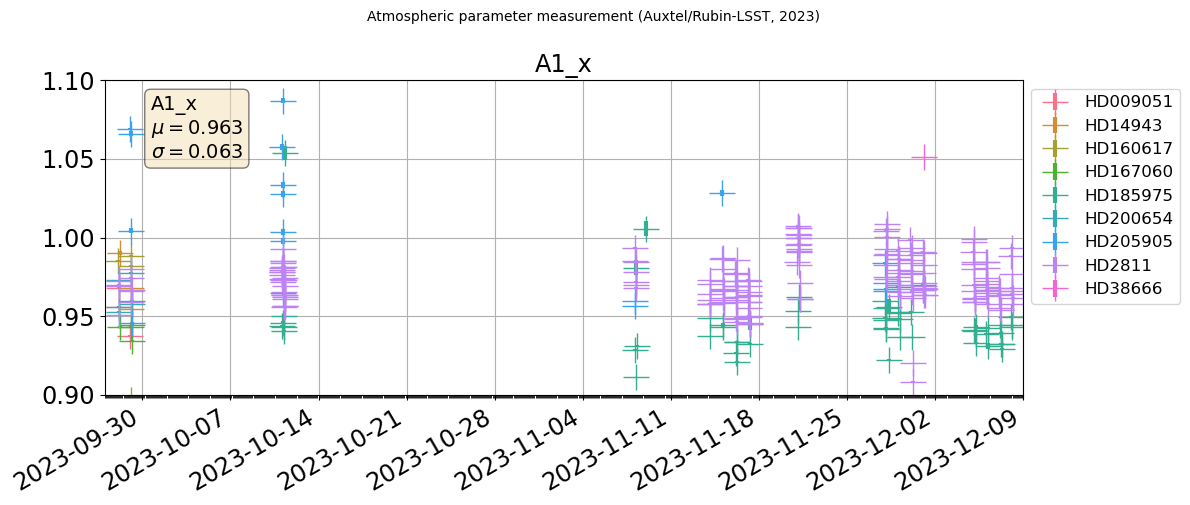

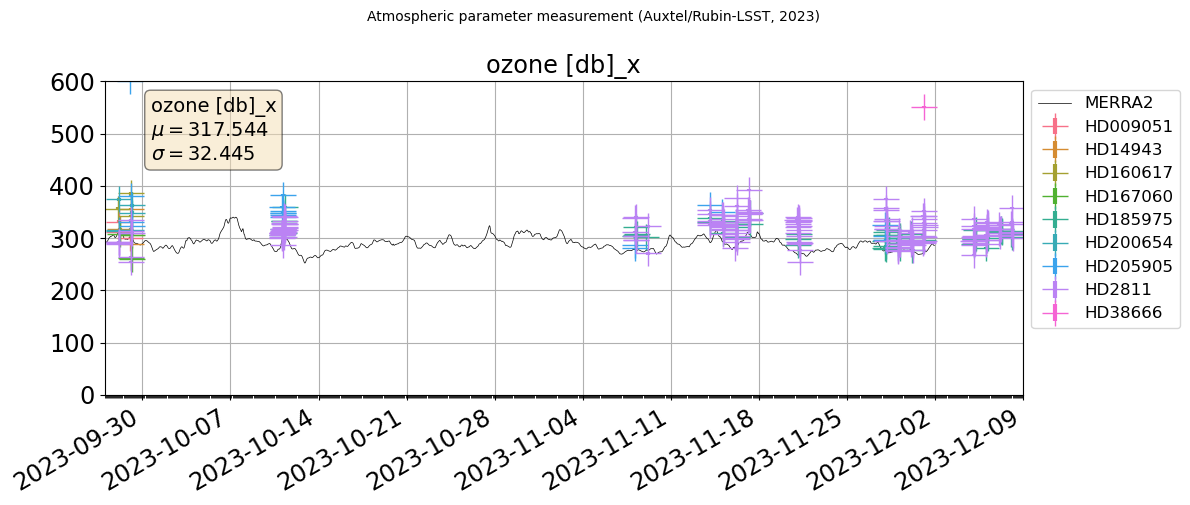

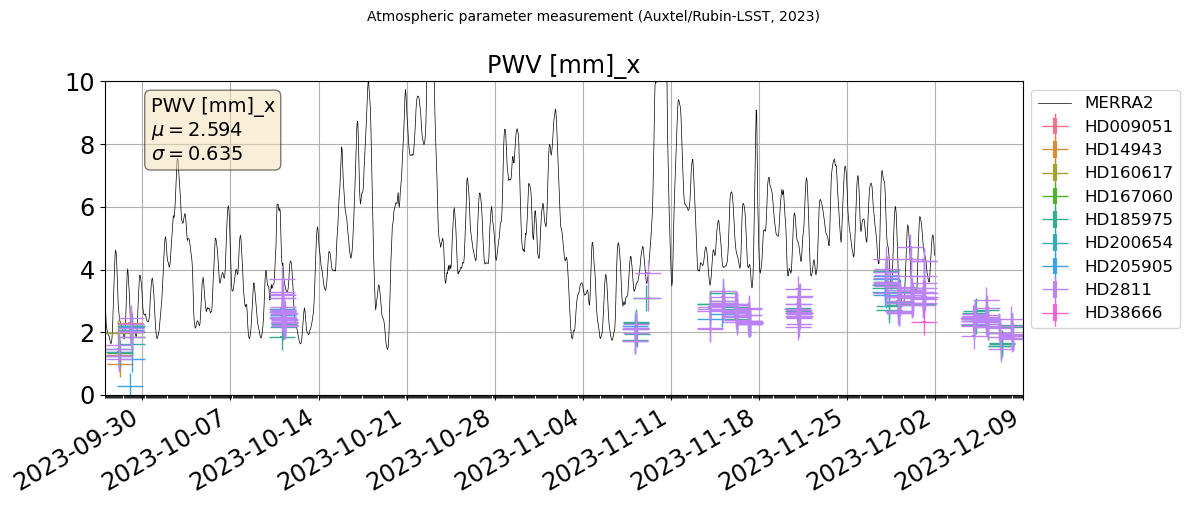

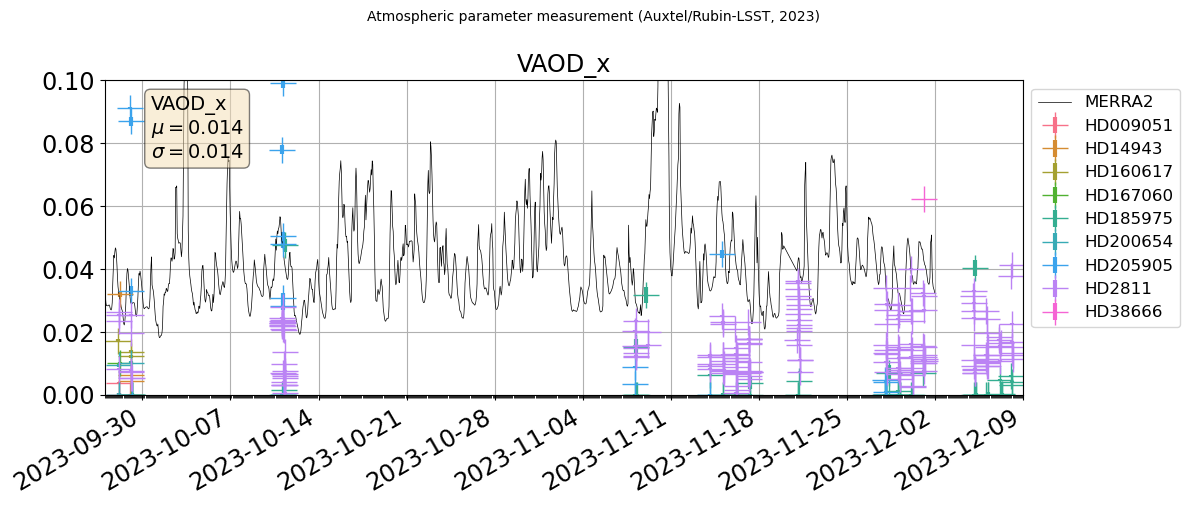

In [41]:
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=7)
hour_locator = mdates.HourLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m-%d") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(12,5))
    for star in stars:
        idxcol = np.where(stars == star)[0][0]
        color = cmap[idxcol]
        
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",color=color,ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",color=color,ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    #ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    #ax.xaxis.set_minor_locator(day_locator)

    ax.xaxis.set_major_locator(day_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(hour_locator)

    ax.xaxis.set_major_formatter(year_month_formatter)
    ax.set_xlim(DATEMIN,DATEMAX)
    plt.gcf().autofmt_xdate()

    if col == "ozone [db]_x":
        ax.plot(pd.to_datetime(df_asm_all.index),df_asm_all.TO3,'k-',lw=0.5,label="MERRA2")
    elif col == "PWV [mm]_x":
        ax.plot(pd.to_datetime(df_asm_all.index),df_asm_all.TQV,'k-',lw=0.5,label="MERRA2")
    elif col == "VAOD_x":
        ax.plot(pd.to_datetime(df_aer_all.index),df_aer_all.TOTEXTTAU,'k-',lw=0.5,label="MERRA2")

    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Atmospheric parameter measurement (Auxtel/Rubin-LSST, 2023) "
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()

    
    plt.show()

In [27]:
df_selectedcol = df[["DATE-OBS","id","nightObs","nightobs_datetime","A1_x","ozone [db]_x","PWV [mm]_x","VAOD_x","A2_x","filtered"]]
df_selectedcol  = df_selectedcol[ df_selectedcol.filtered ] 

In [28]:
df_selectedcol.drop(labels=["filtered"],axis=1, inplace=True)
df_selectedcol

,DATE-OBS,id,nightObs,nightobs_datetime,A1_x,ozone [db]_x,PWV [mm]_x,VAOD_x,A2_x
10,2023-09-28 01:26:38.285000941+00:00,2023092700298,20230927,2023-09-27,0.984981,356.239639,1.980378,1.731166e-02,1.0
17,2023-09-28 02:28:12.446493037+00:00,2023092700350,20230927,2023-09-27,0.972816,374.155254,1.470407,9.425925e-03,1.0
22,2023-09-28 03:02:52.898997244+00:00,2023092700390,20230927,2023-09-27,0.950843,293.167405,1.147037,8.390510e-03,1.0
23,2023-09-28 03:04:05.947505326+00:00,2023092700391,20230927,2023-09-27,0.970062,289.294810,1.234694,2.551534e-02,1.0
27,2023-09-28 03:21:26.175995914+00:00,2023092700407,20230927,2023-09-27,0.956207,313.615766,1.246091,3.694461e-09,1.0
...,...,...,...,...,...,...,...,...,...
567,2023-12-08 03:14:06.988503349+00:00,2023120700399,20231207,2023-12-07,0.968286,309.035259,1.924415,1.691500e-02,1.0
569,2023-12-08 03:43:37.521992488+00:00,2023120700420,20231207,2023-12-07,0.965867,311.222549,1.776529,1.536287e-02,1.0
570,2023-12-08 03:44:50.441503941+00:00,2023120700421,20231207,2023-12-07,0.964335,309.411981,1.867324,1.323390e-02,1.0
571,2023-12-08 04:02:32.741498325+00:00,2023120700434,20231207,2023-12-07,0.957810,301.151518,1.879441,1.128509e-02,1.0


In [29]:
df_selectedcol_bynight_OZ_mean = df_selectedcol.groupby(['nightObs']).mean()["ozone [db]_x"]
df_selectedcol_bynight_OZ_mean.name = "Ozone_mean"
df_selectedcol_bynight_OZ_median = df_selectedcol.groupby(['nightObs']).median()["ozone [db]_x"]
df_selectedcol_bynight_OZ_median.name = "Ozone_median"
df_selectedcol_bynight_OZ_std = df_selectedcol.groupby(['nightObs']).std()["ozone [db]_x"]
df_selectedcol_bynight_OZ_std.name =  "Ozone_std"

/tmp/ipykernel_9289/3377239000.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_selectedcol_bynight_OZ_mean = df_selectedcol.groupby(['nightObs']).mean()["ozone [db]_x"]
/tmp/ipykernel_9289/3377239000.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_selectedcol_bynight_OZ_median = df_selectedcol.groupby(['nightObs']).median()["ozone [db]_x"]
/tmp/ipykernel_9289/3377239000.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid f

In [30]:
df_selectedcol_bynight_PWV_mean = df_selectedcol.groupby(['nightObs']).mean()["PWV [mm]_x"]
df_selectedcol_bynight_PWV_mean.name = "PWV_mean"
df_selectedcol_bynight_PWV_median = df_selectedcol.groupby(['nightObs']).median()["PWV [mm]_x"]
df_selectedcol_bynight_PWV_median.name = "PWV_median"
df_selectedcol_bynight_PWV_std = df_selectedcol.groupby(['nightObs']).std()["PWV [mm]_x"]
df_selectedcol_bynight_PWV_std.name =  "PWV_std"

/tmp/ipykernel_9289/1281020465.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_selectedcol_bynight_PWV_mean = df_selectedcol.groupby(['nightObs']).mean()["PWV [mm]_x"]
/tmp/ipykernel_9289/1281020465.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_selectedcol_bynight_PWV_median = df_selectedcol.groupby(['nightObs']).median()["PWV [mm]_x"]
/tmp/ipykernel_9289/1281020465.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for

In [31]:
df_pwv_oz = pd.concat( [df_selectedcol_bynight_PWV_mean,df_selectedcol_bynight_PWV_median,df_selectedcol_bynight_PWV_std,
                        df_selectedcol_bynight_OZ_mean,df_selectedcol_bynight_OZ_median,df_selectedcol_bynight_OZ_std],axis=1)

### Add datetime conversion

In [32]:
df_pwv_oz["nightobs_datetime"] = pd.to_datetime([convertNumToDatestr(num) for num in df_pwv_oz.index])

In [33]:
df_pwv_oz

,PWV_mean,PWV_median,PWV_std,Ozone_mean,Ozone_median,Ozone_std,nightobs_datetime
nightObs,,,,,,,
20230927,1.376524,1.360643,0.249256,316.253015,312.711896,26.444049,2023-09-27
20230928,1.964846,2.066828,0.460988,329.757659,314.901547,70.948447,2023-09-28
20231010,2.559656,2.466917,0.364077,324.137084,317.235920,19.989018,2023-10-10
20231107,2.052455,2.109460,0.212863,307.742256,304.659232,17.742722,2023-11-07
20231108,3.358373,3.103686,0.459682,298.780719,301.294905,26.248035,2023-11-08
20231113,2.589422,2.714124,0.323287,339.828154,335.853204,13.346971,2023-11-13
20231114,2.947909,2.910641,0.198394,327.926557,327.902541,13.105717,2023-11-14
20231115,2.650787,2.649798,0.183294,319.529046,315.585305,24.484278,2023-11-15
20231116,2.396983,2.323103,0.173909,347.622238,348.054644,14.470652,2023-11-16


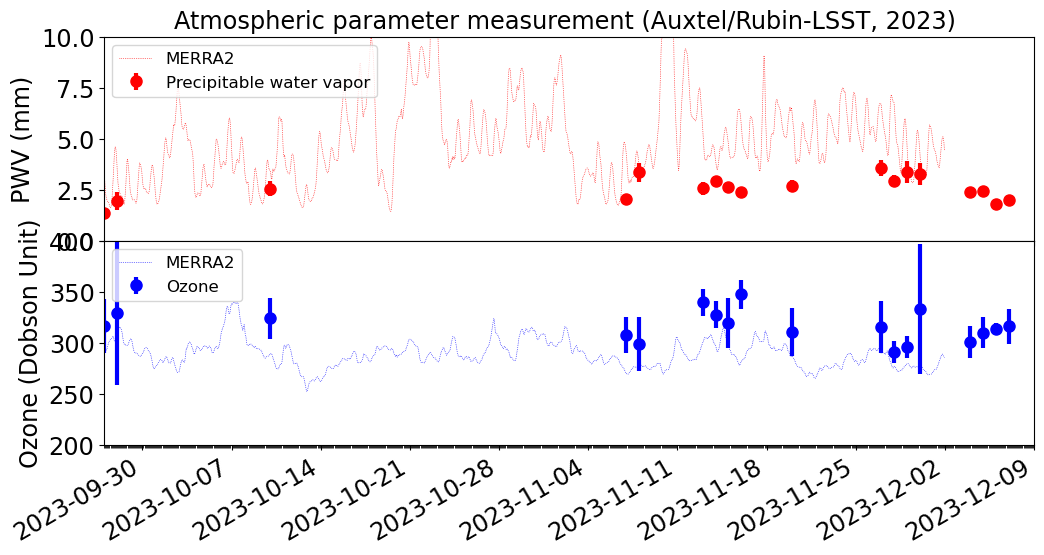

In [44]:
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=7)
hour_locator = mdates.HourLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m-%d") 

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6),sharex=True)
ax1.errorbar(pd.to_datetime(df_pwv_oz["nightobs_datetime"]), df_pwv_oz["PWV_mean"], yerr= df_pwv_oz["PWV_std"], linestyle="none", marker="o",color="r",ms=8,lw=3 ,label="Precipitable water vapor")

ax1.set_ylabel("PWV (mm)")
ax1.plot(pd.to_datetime(df_asm_all.index),df_asm_all.TQV,'r:',lw=0.5,label="MERRA2")
ax1.set_xlim(DATEMIN,DATEMAX)
ax1.set_ylim(0.,10.)
ax1.legend(loc="upper left")

ax2.errorbar(pd.to_datetime(df_pwv_oz["nightobs_datetime"]), df_pwv_oz["Ozone_mean"], yerr= df_pwv_oz["Ozone_std"], linestyle="none", marker="o",color="b",ms=8,lw=3 ,label="Ozone")
ax2.set_ylabel("Ozone (Dobson Unit)")
ax2.set_xlim(DATEMIN,DATEMAX)
ax2.set_ylim(200.,400.)
ax2.plot(pd.to_datetime(df_asm_all.index),df_asm_all.TO3,'b:',lw=0.5,label="MERRA2")
ax2.legend(loc="upper left")

ax2.xaxis.set_major_locator(day_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(hour_locator)
plt.gcf().autofmt_xdate()


suptitle = f"Atmospheric parameter measurement (Auxtel/Rubin-LSST, 2023) "
#plt.suptitle(suptitle,fontsize=10,y=.95)
ax1.set_title(suptitle)

plt.subplots_adjust(wspace=None, hspace=0)

plt.show()